## Triplet Creation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json
import imageio
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#If positive example is (man, next to, bus)
#The negative example will be like (man, leaning on, bus)

import json
import imageio

HOME_DIR = "/content/drive/My Drive/VisRel/"
JSON_DIR = "/content/drive/My Drive/VisRel/new_json_dataset/"

def createTripletExamples(predicate, filename):

  
  f = open(JSON_DIR + "objects.json", 'r')
  objList = json.load(f)

  f = open(JSON_DIR + "predicates.json", 'r')
  predList = json.load(f)

  #From here on you don't need to change anything
  if(filename==JSON_DIR + "annotations_test.json"):
      newFilename = str(HOME_DIR + "triplets_dataset/"+predicate+'_test_triplets.json')
  else:
      newFilename = str(HOME_DIR + "triplets_dataset/"+predicate + '_train_triplets.json')

  data = {'predicate': predicate, 'examples': []}
  def addToData(filename1, filename2, p_bbox1, p_bbox2, n_bbox1, n_bbox2, p_name1, p_name2, n_name1, n_name2, relationship_p, relationship_n):
      row = {}
      row['filename1'] = filename1
      row['filename2'] = filename2

      row['positive'] = {}
      row['negative'] = {}

      row['positive']['bbox1'] = p_bbox1
      row['positive']['bbox2'] = p_bbox2
      row['positive']['obj1'] = p_name1
      row['positive']['obj2'] = p_name2
      row['positive']['relationship'] = relationship_p

      row['negative']['bbox1'] = n_bbox1
      row['negative']['bbox2'] = n_bbox2
      row['negative']['obj1'] = n_name1
      row['negative']['obj2'] = n_name2
      row['negative']['relationship'] = relationship_n

      data['examples'].append(row)


  def getDistance(bb1, bb2):
      bb1_x1 = bb1['x']
      bb1_y1 = bb1['y']
      bb1_w = bb1['w']
      bb1_h = bb1['h']
      bb1_x2 = bb1_x1+bb1_w
      bb1_y2 = bb1_y1+bb1_h

      bb2_x1 = bb2['x']
      bb2_y1 = bb2['y']
      bb2_w = bb2['w']
      bb2_h = bb2['h']
      bb2_x2 = bb2_x1 + bb2_w
      bb2_y2 = bb2_y1 + bb2_h

      dx = min(bb1_x1-bb2_x1, bb1_x1-bb2_x2, bb1_x2-bb2_x1, bb1_x2-bb2_x2)
      dy = min(bb1_y1 - bb2_y1, bb1_y1 - bb2_y2, bb1_y2 - bb2_y1, bb1_y2 - bb2_y2)
      return dx**2 + dy**2

  filter = "JSON file (*.json)|*.json|All Files (*.*)|*.*||"

  existing_tuple_dict = {}

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)

          #Iterate over all images
          k_cnt = 0
          for key in datastore.keys():
            k_cnt += 1
            filename = key

            relationships = datastore[key]
            print(relationships)
            #iterate over all relationships
            for it in range(0, len(relationships)):
              p_relationship = relationships[it]
              print(p_relationship)
              
              p_predicate_id = p_relationship["predicate"]
              p_object_tuple = p_relationship["object"]
              p_subject_tuple = p_relationship["subject"]

              p_object_id = p_object_tuple["category"]
              p_object_bb = p_object_tuple["bbox"]

              p_subject_id = p_subject_tuple["category"]
              p_subject_bb = p_subject_tuple["bbox"]

              p_objname1 = objList[p_object_id]
              p_objname2 = objList[p_subject_id]
              p_predname = predList[p_predicate_id]

              if p_object_id in existing_tuple_dict.keys():
                if existing_tuple_dict[p_object_id] == p_subject_id:
                  continue
              
              existing_tuple_dict[p_object_id] = p_subject_id


              if p_predname != predicate:
                continue

              # addToData(filename, filename, p_object_bb, p_subject_bb, p_object_bb, p_subject_bb, p_objname1, p_objname2,p_objname1, p_objname2, p_predname, p_predname)
              k2_cnt = 0
              flag = 1
              for key2 in datastore.keys():
                if flag == 0:
                  break
                filename2 = key2
                k2_cnt += 1
                if k2_cnt <= k_cnt:
                  continue
                relationships2 = datastore[key2]
                for it2 in range(it+1, len(relationships2)):
                  n_relationship = relationships2[it2]
                
                  n_predicate_id = n_relationship["predicate"]
                  n_object_tuple = n_relationship["object"]
                  n_subject_tuple = n_relationship["subject"]

                  n_object_id = n_object_tuple["category"]
                  n_object_bb = n_object_tuple["bbox"]

                  n_subject_id = n_subject_tuple["category"]
                  n_subject_bb = n_subject_tuple["bbox"]

                  n_objname1 = objList[n_object_id]
                  n_objname2 = objList[n_subject_id]
                  n_predname = predList[n_predicate_id]  

                  if p_predicate_id != n_predicate_id and p_object_id == n_object_id and p_subject_id == n_subject_id:
                    addToData(filename, filename2, p_object_bb, p_subject_bb, n_object_bb, n_subject_bb, p_objname1, p_objname2,n_objname1, n_objname2, p_predname, n_predname)
                    flag = 0
                    break

  with open(newFilename, 'w') as f:
      json.dump(data, f)


In [0]:
filename = JSON_DIR + "annotations_train.json"

predicates = ["on", "next to", "behind", "under"]

cnt = 0
for predicate in predicates:
  createTripletExamples(predicate, filename)
  print(str(cnt+1),": ",predicate," done.")
  cnt += 1

In [0]:
test_filename = JSON_DIR + "annotations_test.json"

predicates = ["on", "next to", "behind", "under"]

cnt = 0
for predicate in predicates:
  createTripletExamples(predicate, test_filename)
  print(str(cnt+1),": ",predicate," done.")
  cnt += 1

In [0]:
import imageio
import matplotlib.pyplot as plt
import numpy as np


def visualizeDataset(filename, numExamples=10):

  #No need to make changes from here
  def getCoordinates(bbox):
      # x = bbox['x']
      # y = bbox['y']
      # w = bbox['w']
      # h = bbox['h']

      # x2 = x+w
      # y2 = y+h

      y = bbox[0]
      y2 = bbox[1]
      
      x = bbox[2]
      x2 = bbox[3]

      x_coordinates = np.array([x,x,x2,x2,x])
      y_coordinates = np.array([y,y2,y2,y,y])
      return x_coordinates, y_coordinates

  import json
  filter = "JSON file (*.json)|*.json|All Files (*.*)|*.*||"

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)
          print("Total Positive Negative Example Pairs for this predicate = ",len(datastore['examples']))
          for it in range(min(len(datastore['examples']),numExamples)):
              filename1 = datastore['examples'][it]['filename1']

              p_bb1 = datastore['examples'][it]['positive']['bbox1']
              p_bb2 = datastore['examples'][it]['positive']['bbox2']

              p_obj1 = datastore['examples'][it]['positive']['obj1']
              p_obj2 = datastore['examples'][it]['positive']['obj2']

              p_pred = datastore['examples'][it]['positive']['relationship']

              img1 = imageio.imread(HOME_DIR + "sg_dataset/sg_train_images/"+filename1)


              plt.subplot(121)
              plt.title("Examples: \n"+p_obj2+", "+p_pred+", "+p_obj1)
              plt.imshow(img1)
              coordinates_x, coordinates_y = getCoordinates(p_bb1)
              plt.plot(coordinates_x, coordinates_y, 'b-')
              coordinates_x, coordinates_y = getCoordinates(p_bb2)
              plt.plot(coordinates_x, coordinates_y, 'b-')

              plt.show()

Total Positive Negative Example Pairs for this predicate =  578


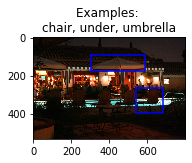

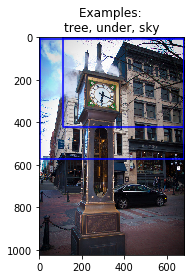

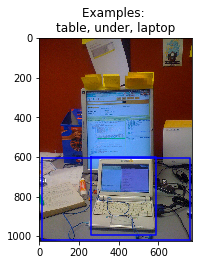

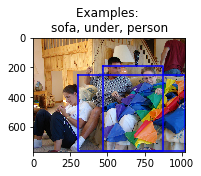

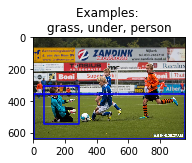

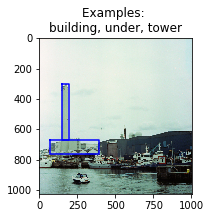

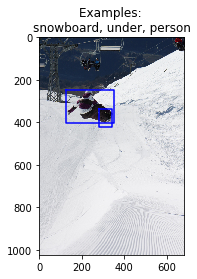

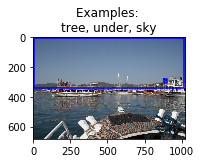

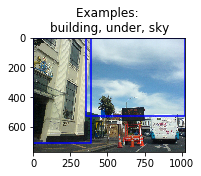

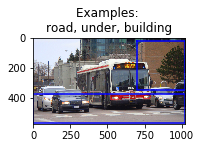

In [6]:
#Just enter filename
filename = HOME_DIR + "triplets_dataset/under_train_triplets.json"

visualizeDataset(filename)

## BoundingBox Mask Generation

In [0]:
def bbox_mask(img_filename, bboxes):
  img1 = imageio.imread(img_filename)

  img1 = np.array(img1)
  img1 = img1*0.0

  img1[bboxes[0]:bboxes[1], bboxes[2]:bboxes[3]] = 0.5    
  img1[bboxes[4]:bboxes[5], bboxes[6]:bboxes[7]] += 1.0
  img1[bboxes[4]:bboxes[5], bboxes[6]:bboxes[7]] /= 2.0
  img1[bboxes[4]:bboxes[5], bboxes[6]:bboxes[7]] /= 0.75
  img1 = rgb2gray(img1)
  img1 = np.array((img1 * 255).astype(np.uint8))
  img1 = Image.fromarray(img1)
  img1 = img1.resize((100, 100), Image.ANTIALIAS)

  img1 = np.array(img1)
  img1 = img1/255.0
  
  img1 = np.reshape(img1, newshape=[1,img1.shape[0],img1.shape[1],1])

  return img1[0][:,:,0]

In [0]:
inputBBImageList = []
outputPredictionsList = []

# add_cnt = 0

def add(item, desc):
  if(desc=="bbimg"):
    inputBBImageList.append(item)
  else:
    outputPredictionsList.append(item)

In [0]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib import cm
from PIL import Image

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
  
predicates = ["on", "next to", "behind", "under"]
p_cnt = 0

for predicate in predicates:
  pred_ex_cnt = 0
  p_cnt += 1
  print(p_cnt)
  filename = HOME_DIR + "couples/"+predicate+"_train_triplets.json"

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)
          index_cnt = 0
          for it in range(0,len(datastore['examples'])):
              if(pred_ex_cnt==1000):
                break
              filename1 = datastore['examples'][it]['filename1']
              filename2 = datastore['examples'][it]['filename2']

              p_bb1 = datastore['examples'][it]['positive']['bbox1']
              p_bb2 = datastore['examples'][it]['positive']['bbox2']
              n_bb1 = datastore['examples'][it]['negative']['bbox1']
              n_bb2 = datastore['examples'][it]['negative']['bbox2']

              p_obj1 = datastore['examples'][it]['positive']['obj1']
              p_obj2 = datastore['examples'][it]['positive']['obj2']
              n_obj1 = datastore['examples'][it]['negative']['obj1']
              n_obj2 = datastore['examples'][it]['negative']['obj2']

              p_pred = datastore['examples'][it]['positive']['relationship']
              n_pred = datastore['examples'][it]['negative']['relationship']

              bboxes = np.array([p_bb1, p_bb2]).flatten()

              img1 = bbox_mask(HOME_DIR + "sg_dataset/sg_train_images/" + filename1, bboxes)

              plt.imshow(img1)
              add(np.array(img1), desc="bbimg")
              add(p_pred, desc="output")

              index_cnt += 1
              pred_ex_cnt += 1
  print(pred_ex_cnt," examples chosen")

In [0]:
predicates = ["on", "next to", "behind", "under"]
pred_dict = {}

pred_id = 0
for predicate in predicates:
  pred_dict[predicate] = pred_id
  pred_id += 1

def getPredId(predicate):
  return pred_dict[predicate]

def getAll():
  total_cnt = len(inputBBImageList)
  inputImg = np.zeros(shape=[total_cnt, 100, 100, 1])
  outputPredictions = np.zeros(shape=[total_cnt, 1])
  
  for i in range(total_cnt):
    inputImg[i,:,:,0] = inputBBImageList[i]
    outputPredictions[i] = pred_dict[outputPredictionsList[i]]
  
  return inputImg, outputPredictions

In [0]:
trainImages, trainPredictions = getAll()

a = trainPredictions.astype(int).flatten()
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1

trainPredictions = b

np.save(HOME_DIR + "trainInputImages.npy", trainImages)
np.save(HOME_DIR + "trainOutputPredictions.npy", trainPredictions)

In [0]:
inputBBImageList = []
outputPredictionsList = []

# add_cnt = 0

def add(item, desc):
  if(desc=="bbimg"):
    inputBBImageList.append(item)
  else:
    outputPredictionsList.append(item)

In [0]:
predicates = ["on", "next to", "behind", "under"]
p_cnt = 0

for predicate in predicates:
  pred_ex_cnt = 0
  p_cnt += 1
  print(p_cnt)
  filename = HOME_DIR + "couples/"+predicate+"_test_triplets.json"

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)
          index_cnt = 0
          for it in range(0,len(datastore['examples'])):
              if(pred_ex_cnt==1000):
                break
              filename1 = datastore['examples'][it]['filename1']
              filename2 = datastore['examples'][it]['filename2']

              if filename1 == "4392556686_44d71ff5a0_o.jpg":
                filename1 = "4392556686_44d71ff5a0_o.gif"
              if filename2 == "4392556686_44d71ff5a0_o.jpg":
                filename2 = "4392556686_44d71ff5a0_o.gif"

              p_bb1 = datastore['examples'][it]['positive']['bbox1']
              p_bb2 = datastore['examples'][it]['positive']['bbox2']
              n_bb1 = datastore['examples'][it]['negative']['bbox1']
              n_bb2 = datastore['examples'][it]['negative']['bbox2']

              p_obj1 = datastore['examples'][it]['positive']['obj1']
              p_obj2 = datastore['examples'][it]['positive']['obj2']
              n_obj1 = datastore['examples'][it]['negative']['obj1']
              n_obj2 = datastore['examples'][it]['negative']['obj2']

              p_pred = datastore['examples'][it]['positive']['relationship']
              n_pred = datastore['examples'][it]['negative']['relationship']

              bboxes = np.array([p_bb1, p_bb2]).flatten()

              img1 = bbox_mask(HOME_DIR + "sg_dataset/sg_test_images/" + filename1, bboxes)

              plt.imshow(img1)
              add(np.array(img1), desc="bbimg")
              add(p_pred, desc="output")

              index_cnt += 1
              pred_ex_cnt += 1
  print(pred_ex_cnt," examples chosen")

In [0]:
testImages, testPredictions = getAll()

a = testPredictions.astype(int).flatten()
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1

testPredictions = b

np.save(HOME_DIR + "testInputImages.npy", testImages)
np.save(HOME_DIR + "testOutputPredictions.npy", testPredictions)

In [0]:
print(index_cnt)
print(len(inputBBImageList))

print(trainImages.shape)
print(trainPredictions.shape)

print(testImages.shape)
print(testPredictions.shape)

55
923
(3578, 100, 100, 1)
(3578, 4)
(923, 100, 100, 1)
(923, 4)


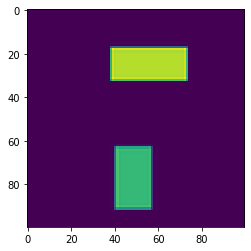

In [0]:
plt.imshow(trainImages[0][:,:,0])

## Training a classifier

In [0]:
trainImages = np.load(HOME_DIR + "trainInputImages.npy")
trainLabels = np.load(HOME_DIR + "trainOutputPredictions.npy")

In [0]:
testImages = np.load(HOME_DIR + "testInputImages.npy")
testLabels = np.load(HOME_DIR + "testOutputPredictions.npy")

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
import numpy as np

Using TensorFlow backend.


In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(4, activation = 'softmax'))













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 49, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 96)       

In [0]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [0]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/VisRel/models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [13]:
model.compile(loss=focal_loss(alpha=1), optimizer='adam', metrics = ['accuracy',f1_m,precision_m, recall_m])

In [0]:
# model.load_weights(HOME_DIR + "models/classifier_weights_50.h5")

In [14]:
model.fit(trainImages, trainLabels, validation_data=(testImages, testLabels), batch_size = 32, epochs = 100, verbose = 1, callbacks = [checkpoint, reduce_lr_loss])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3578 samples, validate on 923 samples
Epoch 1/100
3578/3578 [==============================] - 7s 2ms/step - loss: 0.8057 - acc: 0.3105 - f1_m: 0.0392 - precision_m: 0.2932 - recall_m: 0.0218 - val_loss: 0.7212 - val_acc: 0.3933 - val_f1_m: 0.1331 - val_precision_m: 0.4071 - val_recall_m: 0.0802

Epoch 00001: val_loss improved from inf to 0.72122, saving model to /content/drive/My Drive/VisRel/models/model-001-0.310509-0.393283.h5
Epoch 2/100
3578/3578 [==============================] - 4s 1ms/step - loss: 0.7348 - acc: 0.3544 - f1_m: 0.0326 - precision_m: 0.3339 - recall_m: 0.0173 - val_loss: 0.6900 - val_acc: 0.4139 - val_f1_m: 0.0965 - val_precision_m: 0.4022 - val_recall_m: 0.0563

Epoch 00002: val_loss improved from 0.72122 to 0.69002, saving model to /content/drive/My Drive/VisRel/models/model-002-0.354388-0.413868.h5
Epoch 3/100
3578/3578 [==============================] - 4s

In [0]:
# model.save_weights('/content/drive/My Drive/VisRel/models/model-100-0.8298-0.5580.h5')

## Testing

In [0]:
%load_ext autoreload
%autoreload 2
import torchvision
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model2.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 79.8MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [0]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model2([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [0]:
import numpy as np
def object_detection_api(img_path, sub, obj, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  
  sub_list=[]
  obj_list=[]

  for i in range(len(boxes)):
    if(pred_cls[i]==sub):
      sub_list.append(i)
    if(pred_cls[i]==obj):
      obj_list.append(i)

  imgList = []
  # print(sub_list)
  # print(obj_list)

  for i1 in range(len(sub_list)):
    for j1 in range(len(obj_list)):
      if(sub_list[i1]==obj_list[j1]):
        continue
      plt.clf()
      img1 = np.array(img)
      img2 = np.array(img)
      img1 = img1*0.0
      i = sub_list[i1]
      # print(boxes[i])
      # print(int(min(boxes[i][1]))," ",int(max(boxes[i][1]))," : ",int(min(boxes[i][0]))," ",int(max(boxes[i][0])))
      img_bbox = np.zeros(shape=[8], dtype=np.int32)
      img_bbox[0] = int(min(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[1] = int(max(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[2] = int(min(boxes[i][0][0], boxes[i][1][0]))
      img_bbox[3] = int(max(boxes[i][0][0], boxes[i][1][0]))
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] = 0.5
      
      i = obj_list[j1]
      # print(boxes[i])
      img_bbox[4] = int(min(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[5] = int(max(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[6] = int(min(boxes[i][0][0], boxes[i][1][0]))
      img_bbox[7] = int(max(boxes[i][0][0], boxes[i][1][0]))

      imgList.append(img_bbox)

      # print(int(min(boxes[i][1]))," ",int(max(boxes[i][1]))," : ",int(min(boxes[i][0]))," ",int(max(boxes[i][0])))
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] += 1.0
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] /= 2.0
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] /= 0.75
      # plt.subplot(121)
      # plt.imshow(img1)
      

      i = sub_list[i1]
      cv2.rectangle(img2, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
      cv2.putText(img2,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class

      

      
      i = obj_list[j1]

      cv2.rectangle(img2, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
      cv2.putText(img2,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
      # plt.subplot(122)
      # plt.imshow(img2)
      # plt.show()
  
  final_img_bbox = np.zeros(shape=[len(imgList),8], dtype=np.int32)
  for i in range(len(imgList)):
    final_img_bbox[:] = imgList[i]
  return final_img_bbox

      

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [0]:
model.load_weights("/content/drive/My Drive/VisRel/models/model-015-0.628004-0.518960.h5")
# model.load_weights("/content/drive/My Drive/VisRel/models/model-100-0.8298-0.5580.h5")

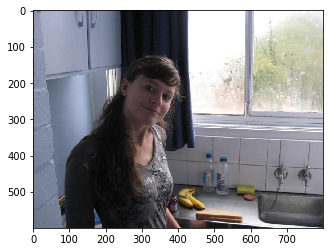

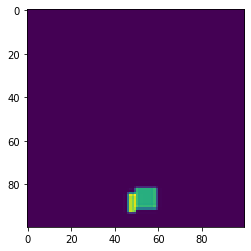

[[0.3344913  0.3504725  0.20154825 0.11348792]]
next to


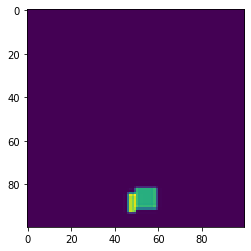

[[0.3344913  0.3504725  0.20154825 0.11348792]]
next to


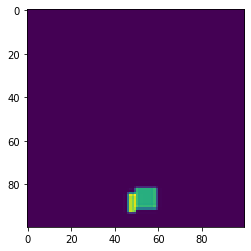

[[0.3344913  0.3504725  0.20154825 0.11348792]]
next to


In [40]:
# filename = HOME_DIR + "sg_dataset/sg_train_images/10007531244_0f2c46cf70_b.jpg"
# subject = "cup"
# predicate = "next to"
# obj = "person"

# filename = HOME_DIR + "sg_dataset/sg_train_images/1589782798_1412fcabd5_o.jpg"
# subject = "person"
# predicate = "under"
# obj = "umbrella"

filename = HOME_DIR + "sg_dataset/sg_train_images/2637269067_618d25375b_o.jpg"
subject = "banana"
predicate = "next to"
obj = "bottle"


img = imageio.imread(filename)
plt.imshow(img)
plt.show()

bboxes = object_detection_api(filename, subject, obj)

for i in range(bboxes.shape[0]):
  img1 = np.array(img)
  img1 = img1*0.0

  img1[bboxes[i,0]:bboxes[i,1], bboxes[i,2]:bboxes[i,3]] = 0.5    
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] += 1.0
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] /= 2.0
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] /= 0.75
  img1 = rgb2gray(img1)
  img1 = np.array((img1 * 255).astype(np.uint8))
  img1 = Image.fromarray(img1)
  img1 = img1.resize((100, 100), Image.ANTIALIAS)

  img1 = np.array(img1)
  img1 = img1/255.0
  
  plt.imshow(img1)
  plt.show()

  img1 = np.reshape(img1, newshape=[1,img1.shape[0],img1.shape[1],1])

  y_pred = model.predict(x=[img1])
  predicates = ["on", "next to", "behind", "under"]
  print(y_pred)
  print(predicates[np.argmax(y_pred)])
  